In [144]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict

In [3]:
%load_ext watermark
%watermark -a 'Moon Jeong-Hyeon' -u -d -p numpy,pandas,matplotlib,sklearn

Moon Jeong-Hyeon 
last updated: 2020-06-21 

numpy 1.18.1
pandas 1.0.2
matplotlib 3.1.3
sklearn 0.0


**NOTE** 코딩해야할 부분을 제외하고는 수정하지 마세요.

# DATA LOAD

In [418]:
# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context  

In [143]:
mnist_sci = fetch_openml('mnist_784')

In [145]:
x_train, x_test, y_train_, y_test_ = train_test_split(mnist_sci.data, mnist_sci.target, 
                                                    test_size = 0.1,
                                                   shuffle = True)
x_train /= 255.0
x_test /= 255.0
x_train = x_train.reshape(-1,1,28,28)
x_test = x_test.reshape(-1,1,28,28)

def one_hoy_label(X):
    T = np.zeros((X.size, 10))    
    for idx, row in enumerate(T):
        row[int(X[idx])] = 1
        
    return T

y_train = one_hoy_label(y_train_)
y_test = one_hoy_label(y_test_)

In [146]:
class Softmax_CE:
    """
    편의를 위해서 softmax와 crossenropy를 결합한 것입니다.
    """
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = CE_loss(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

## 문제 1 에서 구현한 것을 바탕으로 CNN도 적용됩니다.

In [147]:
def softmax(x):
    x = x.T
    x = x-np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

In [148]:
def CE_loss(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    ce = -np.sum(t*np.log(y))
    ce /= batch_size
    return ce

In [149]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [150]:
class FClayer:
    def __init__(self, W, b):
        
        self.W = W
        self.b = b 
        self.x = None

        self.original_x_shape = None
        
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)
        return dx

## HW10 시작

In [151]:
a = x_train[0:100]
b1 = 0.01 * np.random.randn(3, 1, 3, 3)
c1 = np.zeros(3)

b2 = 0.01 * np.random.randn(int(3 * (26/2) * (26/2)), 16)
c2 = np.zeros(16)

b3 = 0.01 * np.random.randn(16, 10)
c3 = np.zeros(10)

# network = SimpleConvNet(input_dim=(1,28,28), 
#                         conv_param = {'filter_num': 3, 'filter_size': 3, 'pad': 0, 'stride': 1},
#                         hidden_size=16, output_size=10)s

In [152]:
conv_layer = Conv(b1, c1, stride = 1 , pad = 0)
out = conv_layer.forward(a)
out.shape

(100, 3, 26, 26)

In [153]:
r = Relu()
out = r.forward(out)
out.shape

(100, 3, 26, 26)

In [154]:
m = MaxPooling(pool_h = 2, pool_w = 2, stride = 2)
out = m.forward(out)
out.shape

(100, 3, 13, 13)

In [155]:
fc1_layer = FClayer(b2, c2)
fc_out = fc1_layer.forward(out)
fc_out.shape

(100, 16)

In [156]:
r2 = Relu()
relu2_out = r2.forward(fc_out)

fc2_layer = FClayer(b3, c3)
fc2_out = fc2_layer.forward(relu2_out)

sce = Softmax_CE()
loss = sce.forward(fc2_out, y_train[:100])
loss

2.302586271546324

In [157]:
dout = sce.backward(1)
dout = fc2_layer.backward(dout)
dout = r2.backward(dout)
dout = fc1_layer.backward(dout)
dout.shape

(100, 3, 13, 13)

In [158]:
dout_pooling = m.backward(dout)
dout_relu1 = r.backward(dout_pooling)
dout_relu1.shape

(100, 3, 26, 26)

In [159]:
dout_conv = conv_layer.backward(dout_relu1)
dout_conv.shape

(100, 1, 28, 28)

In [160]:
grads = {}
grads['W1'], grads['b1'] = b1, c1
grads['W2'], grads['b2'] = b2, c2
grads['W3'], grads['b3'] = b3, c3

new_grads = {}
new_grads['W1'], new_grads['b1'] = conv_layer.dW, conv_layer.db
new_grads['W2'], new_grads['b2'] = fc1_layer.dW, fc1_layer.db
new_grads['W3'], new_grads['b3'] = fc2_layer.dW, fc2_layer.db

In [161]:
class Conv():
    def __init__(self, W, b, stride=1, pad=0):
        super().__init__()
        
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None   
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None
        
        self.out_h = None
        self.out_w = None
        
    
    def forward(self, x):
        # backward 의 shape 확인을 위해서 저장
        self.x = x[:]        
        
        FN, C_, FH, FW = self.W.shape
        N, C, H, W = x.shape
        
        # output 출력 shape 
        self.out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        self.out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        out_h = self.out_h
        out_w = self.out_w        
        
        # padding
        pad_x = np.pad(
            x, 
            ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), 
            "constant", constant_values=0
        )        
        out = np.zeros((N, FN, out_h, out_w))        
        for n in range(N):
            for f in range(FN):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-1-1 forward를 구현 하세요                                   #
                        ######################################################################
                        result = pad_x[n, :, j*self.stride : j*self.stride+FH, 
                            i*self.stride : i*self.stride + FW] * self.W[f]
                        out[n][f][j][i] += np.sum(result) + self.b[f]
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
        return out

    def backward(self, dout):
        
        FN, C, FH, FW = self.W.shape
        N, C, H, W = self.x.shape
        
        out_h = self.out_h
        out_w = self.out_w
        
        # padding
        pad_x = np.pad(
            self.x, 
            ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), 
            "constant", constant_values=0
        )
        
        dx = np.zeros(pad_x.shape)
        dw = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)

        for n in range(N):
            for f in range(FN):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-1-2 backward 구현 하세요                                    #
                        ######################################################################
                        dw[f] += pad_x[n, : , j* self.stride : j*self.stride + FH, 
                            i*self.stride: i*self.stride + FW] * dout[n][f][j][i]
                        dx[n, :, j*self.stride: j*self.stride + FH, 
                            i*self.stride: i*self.stride + FW] += self.W[f] * dout[n, f, j, i]
                db[f] = np.sum(dout[n,f,:,:])
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
        # remove padding
        dx = dx[:, :, self.pad:dx.shape[2]-self.pad, self.pad:dx.shape[3]-self.pad]
        
        self.db = db
        self.dW = dw
        
        return dx

In [172]:
class MaxPooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None

    def forward(self, x):
        self.x = x[:]
        N, C, H, W = x.shape
        
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        out = np.zeros((N, C, out_h, out_w))
        for j in range(out_h):
            for i in range(out_w):
                ######################################################################
                # 문제 2-2-1 forward를 구현 하세요                                   #
                ######################################################################
                out[:, :, j, i] = np.max(self.x[:, :, j*self.stride : j*self.stride + self.pool_h, 
                    i*self.stride : i*self.stride + self.pool_w])
                ######################################################################
                #                          END OF YOUR CODE                          #
                ######################################################################
        return out

    def backward(self, dout):
        
        N, C, H, W = self.x.shape
        out_h = (H-self.pool_h) // self.stride + 1
        out_w = (W-self.pool_w) // self.stride + 1

        dx = np.zeros(self.x.shape)
        for n in range(N):
            for c in range(C):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-2-2 backward를 구현 하세요                                  #
                        ######################################################################   
                        arr = self.x[n, c, j*self.stride: j*self.stride + self.pool_h, 
                            i*self.stride : i*self.stride + self.pool_w]
                        idx = np.nanargmax(arr)
                        (a, b) = np.unravel_index(idx, arr.shape)
                        dx[n][c][j*self.stride + a][i*self.stride + b] = dout[n][c][j][i]
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
        return dx

In [173]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        weight_init_std = 0.01
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = MaxPooling(pool_h=2, pool_w=2, stride=2)
        self.layers['FClayer1'] = FClayer(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['FClayer2'] = FClayer(self.params['W3'], self.params['b3'])

        self.last_layer = Softmax_CE()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        ######################################################################
        #  2-3 해당 주어진 gradient 함수에 주석을 다세요                     #
        ######################################################################
        # forward
        self.loss(x, t)

        # loss 함수에서 predict 함수를 호출한다.
        # predict 함수 내에서 각 layer의 foward을 순서대로 진행하여
        # 하나의 forward prop이 끝난 에측값을 loss 함수에 return 한다.
        # loss 함수는 softmax_CE의 forward 함수를 호출하여 loss를 계산한다. 

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        # softmax_CE의 backward 함수를 호출하여
        # 전파하는 값을 배치의 수로 나눈 결과, 즉 데이터 1개당 오차를 return 받는다.

        layers = list(self.layers.values())
        layers.reverse()
        # forward prop과 반대 방향으로 backward prop을 진행해야 하기 때문에 
        # layers의 순서를 뒤집는다.
        for layer in layers:
            dout = layer.backward(dout)
        # 각 layer의 backward를 진행하여 dout을 갱신한다.
        # back propagation은 끝에서부터 미분값을 곱해나가는 구조이기 때문에
        # 다음 layer의 input으로 그 전 layer의 output인 dout을 다시 넣어주는 recursive한 형태이다.

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['FClayer1'].dW, self.layers['FClayer1'].db
        grads['W3'], grads['b3'] = self.layers['FClayer2'].dW, self.layers['FClayer2'].db
        # 각 layer의 gradient값을 grads 객체 안에 저장하여 갱신할 매개변수들을 return 한다.
        return grads

In [174]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 3, 'filter_size': 3, 'pad': 0, 'stride': 1},
                        hidden_size=16, output_size=10)

In [175]:
def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

## 학습이 되기전 conv layer 의 파라미터값

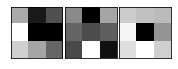

In [176]:
filter_show(network.params['W1'])

In [181]:
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

test_acc_list = []
epochs = 3
step = int(train_size / batch_size)

for epoch in range(epochs):
    for batch_idx in range(step):
        x_batch = x_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        y_batch = y_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        grad = network.gradient(x_batch, y_batch)


        # 매개변수 갱신
        for key in network.params.keys():
            network.params[key] -= learning_rate * grad[key]

        # 학습 경과 기록
        loss = network.loss(x_batch, y_batch)
        print(loss)
    test_acc = network.accuracy(x_test, y_test)
    test_acc_list.append(test_acc)
    print(" test acc | " + str(test_acc))

1608745
2.2947127369810967
2.3039757984220652
2.3023981812629275
2.300281687977349
2.2992478412044606
2.3022684121700023
2.3093818492798035
2.2965643165191043
2.307938371848641
2.3000401976466964
2.301830393277782
2.296881165206944
2.306703175714371
2.305298492380674
2.305690216654577
2.3050447151891613
2.3010853226693357
2.3073136111619506
2.299754418745842
2.2949917693356197
2.297643413183891
2.3075672031862755
2.2959211587234085
2.29815971966851
2.2973674438910017
2.3016093140115923
2.302680317972454
2.30946334095803
2.3111936408275375
2.3029186083129973
2.2998996215489638
2.29437032246162
2.3010864076036435
2.3016873641817286
2.3062916411630794
2.3012807108722186
2.299242056437366
2.3025054848117863
2.2957967081661645
2.2955333897046817
2.2996526044261567
2.303698124989282
2.3028338511044146
2.2994624302349638
2.2883140418873937
2.29430222298086
2.3047564627941046
2.297976959889409
2.2966788649526144
2.301992901725944
2.297120212328699
2.304590356280156
2.2942514846159514
2.3084788

## 학습 후 파라미터 값

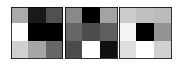

In [179]:
######################################################################
#  2-4 학습된 필터를 캡처하여 제출하세요                             #
######################################################################
filter_show(network.params['W1'])